In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

Separar datos

In [61]:
train_df = pd.read_csv("boneage-training-dataset.csv")
print(train_df.shape)

(12611, 3)


Mostrar datos

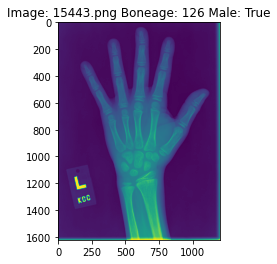

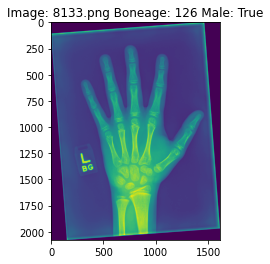

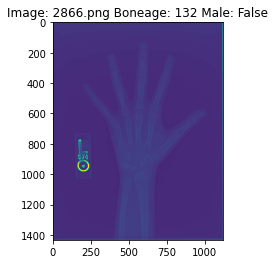

In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_id, boneage, male in train_df[['id','boneage','male']].sample(3).values:
    img_name = str(img_id) + '.png'
    img = mpimg.imread("./boneage-training-dataset/boneage-training-dataset/"+img_name)
    plt.imshow(img)
    plt.title('Image: {} Boneage: {} Male: {}'.format(img_name, boneage, male))
    plt.show()

In [63]:
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def read_and_prep_images(img_paths, img_height, img_width, color_mode="grayscale"):
    imgs = [load_img(img_path, target_size=(img_height, img_width), color_mode=color_mode) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = preprocess_input(img_array)
    return(img_array)

In [64]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

# quadratic approach
quadratic = True
image_size = 128

# some kind of ratio if not quadratic approach
img_rows = image_size if quadratic else 144 
img_cols = image_size if quadratic else 114

initial_model = Sequential()

# Input Layer
initial_model.add(Conv2D(12, kernel_size=(4,4), activation='relu', input_shape=(img_rows, img_cols, 1)))


# Convulotional Layers
initial_model.add(Conv2D(20, kernel_size=(4,4), activation='relu'))
initial_model.add(Conv2D(20, kernel_size=(3,3), activation='relu'))

# Flattening
initial_model.add(Flatten())

# Dense Layer
initial_model.add(Dense(100))
initial_model.add(Dense(1, activation="linear"))

initial_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [65]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout

bone_age_model = Sequential()

# Input Layer
bone_age_model.add(Conv2D(16, kernel_size=(7,7), strides=(2,2), activation='relu', input_shape=(img_rows, img_cols, 3)))
bone_age_model.add(Dropout(0.25))

# Convulotional Layers
bone_age_model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu'))
bone_age_model.add(Dropout(0.25))
bone_age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#bone_age_model.add(Dropout(0.25))
bone_age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
bone_age_model.add(Dropout(0.25))

# Flattening
bone_age_model.add(Flatten())

# Dense Layer
bone_age_model.add(Dense(256, activation='relu'))
#bone_age_model.add(Dropout(0.25))
bone_age_model.add(Dense(1, activation="linear"))

bone_age_model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')

In [66]:
from keras.preprocessing.image import ImageDataGenerator


train_df['imagepath'] = [f'{pid}.png' for pid in train_df.id]
#Lazy way of creating training and test set.
train = train_df.head(10000)
test = train_df.tail(2600)


datagen=ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                           width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                           horizontal_flip=True, fill_mode="nearest")
train_generator=datagen.flow_from_dataframe(dataframe=train, 
                                            directory="./boneage-training-dataset/boneage-training-dataset/", 
                                            x_col="imagepath", 
                                            y_col="boneage", 
                                            class_mode="raw", 
                                            target_size=(img_rows,img_cols), 
                                            batch_size=100)

valid_generator=datagen.flow_from_dataframe(dataframe=test, 
                                            directory="./boneage-training-dataset/boneage-training-dataset/", 
                                            x_col="imagepath", 
                                            y_col="boneage", 
                                            class_mode="raw", 
                                            target_size=(img_rows,img_cols), 
                                            batch_size=100)

Found 10000 validated image filenames.
Found 2600 validated image filenames.


In [67]:


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = bone_age_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
100/100 [==============================] - 991s 10s/step - loss: 5115.0088 - accuracy: 1.0000e-04 - val_loss: 1483.7391 - val_accuracy: 0.0000e+00
Epoch 2/15
100/100 [==============================] - 923s 9s/step - loss: 1751.0708 - accuracy: 1.0000e-04 - val_loss: 1546.0358 - val_accuracy: 0.0000e+00
Epoch 3/15
100/100 [==============================] - 915s 9s/step - loss: 1754.7848 - accuracy: 1.0000e-04 - val_loss: 1491.7081 - val_accuracy: 0.0000e+00
Epoch 4/15
100/100 [==============================] - 974s 10s/step - loss: 1757.3540 - accuracy: 1.0000e-04 - val_loss: 1493.9905 - val_accuracy: 0.0000e+00
Epoch 5/15
100/100 [==============================] - 1216s 12s/step - loss: 1720.0084 - accuracy: 1.0000e-04 - val_loss: 1486.9785 - val_accuracy: 0.0000e+00
Epoch 6/15
100/100 [==============================] - 1011s 10s/step - loss: 1680.2826 - accuracy: 1.0000e-04 - val_loss: 1423.1963 - v

Guardar el modelo

In [68]:
bone_age_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 61, 61, 16)        2368      
_________________________________________________________________
dropout_6 (Dropout)          (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 32)        12832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 25, 25, 128)       73856     
_________________________________________________________________
dropout_8 (Dropout)          (None, 25, 25, 128)      

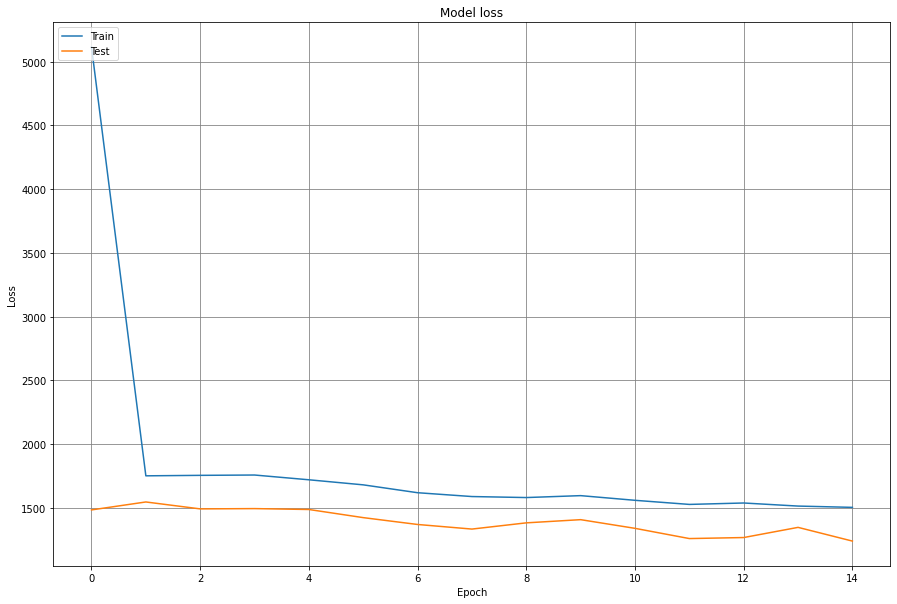

In [69]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
f, ax = plt.subplots(1,1, figsize=(15,10))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
ax.grid(color='grey')
plt.show()

In [70]:
bone_age_model.save_weights('seqModelo_weights_lineal.h5')

<h1>Modelo lineal con 10 Epochs</h1>

In [13]:
load_age_model = Sequential()
load_age_model.add(Conv2D(16, kernel_size=(7,7), strides=(2,2), activation='relu', input_shape=(img_rows, img_cols, 3)))
load_age_model.add(Dropout(0.25))

# Convulotional Layers
load_age_model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu'))
load_age_model.add(Dropout(0.25))
load_age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#bone_age_model.add(Dropout(0.25))
load_age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
load_age_model.add(Dropout(0.25))

# Flattening
load_age_model.add(Flatten())

# Dense Layer
load_age_model.add(Dense(256, activation='relu'))
#bone_age_model.add(Dropout(0.25))
load_age_model.add(Dense(1, activation="linear"))

load_age_model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')

In [14]:
load_age_model.load_weights('seqModelo_weights_lineal_10.h5')

1/1 [==============================] - 0s 0s/step


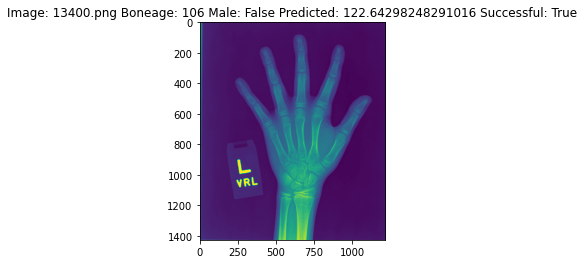

1/1 [==============================] - 0s 1ms/step


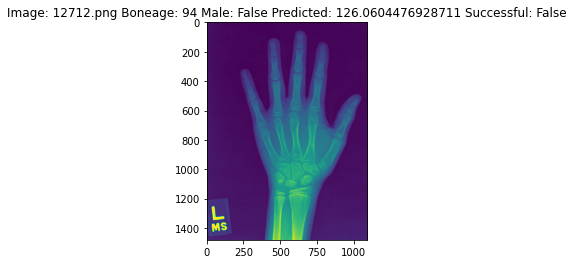

1/1 [==============================] - 0s 965us/step


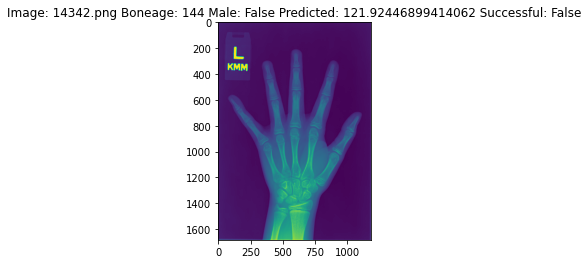

In [49]:
for img_id, boneage, male in test[['id','boneage','male']].sample(3).values:
    filepath = ("./boneage-training-dataset/boneage-training-dataset/"+str(img_id)+".png")
    image = tf.keras.preprocessing.image.load_img(filepath, target_size=(img_rows,img_cols))
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr=input_arr/256
    predictions = load_age_model.predict(input_arr,  verbose = True)
    img_name = str(img_id) + '.png'
    img = mpimg.imread("./boneage-training-dataset/boneage-training-dataset/"+img_name)
    plt.imshow(img)
    dif = boneage-prediction[0][0]
    plt.title('Image: {} Boneage: {} Male: {} Predicted: {} Successful: {}'.format(img_name, boneage, male, predictions[0][0], (dif<4.2 and dif>-4.2)))
    plt.show()

In [16]:
from tkinter import filedialog
filepath = filedialog.askopenfilename()
print(filepath)

C:/Users/Blinkout/Downloads/ModeloSecuencial/boneage-training-dataset/boneage-training-dataset/15609.png


1/1 [==============================] - 0s 0s/step


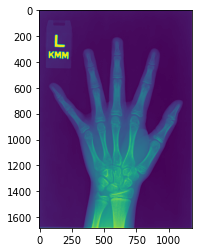

In [57]:
import tensorflow as tf
import PIL

image = tf.keras.preprocessing.image.load_img(filepath, target_size=(img_rows,img_cols))
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr=input_arr/256
predictions = load_age_model.predict(input_arr,  verbose = True)
img = mpimg.imread(filepath)
plt.imshow(img)
plt.show()

In [58]:
res=[]
for i in range(12705,15611):
    try:
        filepath = ("./boneage-training-dataset/boneage-training-dataset/"+str(i)+".png")
        print(filepath)
        image = tf.keras.preprocessing.image.load_img(filepath, target_size=(img_rows,img_cols))
        input_arr = keras.preprocessing.image.img_to_array(image)
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        input_arr=input_arr/256
        predictions = load_age_model.predict(input_arr,  verbose = True)
        res.append(predictions[0][0])
        print(i)
    except:
        pass
print(res)

./boneage-training-dataset/boneage-training-dataset/12705.png
1/1 [==============================] - 0s 0s/step
12705
./boneage-training-dataset/boneage-training-dataset/12706.png
1/1 [==============================] - 0s 2ms/step
12706
./boneage-training-dataset/boneage-training-dataset/12707.png
1/1 [==============================] - 0s 1ms/step
12707
./boneage-training-dataset/boneage-training-dataset/12708.png
./boneage-training-dataset/boneage-training-dataset/12709.png
1/1 [==============================] - 0s 963us/step
12709
./boneage-training-dataset/boneage-training-dataset/12710.png
1/1 [==============================] - 0s 2ms/step
12710
./boneage-training-dataset/boneage-training-dataset/12711.png
1/1 [==============================] - 0s 999us/step
12711
./boneage-training-dataset/boneage-training-dataset/12712.png
1/1 [==============================] - 0s 0s/step
12712
./boneage-training-dataset/boneage-training-dataset/12713.png
1/1 [==============================] - 0s

1/1 [==============================] - 0s 991us/step
12775
./boneage-training-dataset/boneage-training-dataset/12776.png
1/1 [==============================] - 0s 965us/step
12776
./boneage-training-dataset/boneage-training-dataset/12777.png
1/1 [==============================] - 0s 1ms/step
12777
./boneage-training-dataset/boneage-training-dataset/12778.png
1/1 [==============================] - 0s 1ms/step
12778
./boneage-training-dataset/boneage-training-dataset/12779.png
1/1 [==============================] - 0s 1ms/step
12779
./boneage-training-dataset/boneage-training-dataset/12780.png
1/1 [==============================] - 0s 982us/step
12780
./boneage-training-dataset/boneage-training-dataset/12781.png
1/1 [==============================] - 0s 3ms/step
12781
./boneage-training-dataset/boneage-training-dataset/12782.png
1/1 [==============================] - 0s 997us/step
12782
./boneage-training-dataset/boneage-training-dataset/12783.png
./boneage-training-dataset/boneage-train

1/1 [==============================] - 0s 997us/step
12921
./boneage-training-dataset/boneage-training-dataset/12922.png
1/1 [==============================] - 0s 0s/step
12922
./boneage-training-dataset/boneage-training-dataset/12923.png
1/1 [==============================] - 0s 997us/step
12923
./boneage-training-dataset/boneage-training-dataset/12924.png
1/1 [==============================] - 0s 1ms/step
12924
./boneage-training-dataset/boneage-training-dataset/12925.png
1/1 [==============================] - 0s 0s/step
12925
./boneage-training-dataset/boneage-training-dataset/12926.png
1/1 [==============================] - 0s 1ms/step
12926
./boneage-training-dataset/boneage-training-dataset/12927.png
1/1 [==============================] - 0s 2ms/step
12927
./boneage-training-dataset/boneage-training-dataset/12928.png
./boneage-training-dataset/boneage-training-dataset/12929.png
1/1 [==============================] - 0s 996us/step
12929
./boneage-training-dataset/boneage-training-

1/1 [==============================] - 0s 1ms/step
12994
./boneage-training-dataset/boneage-training-dataset/12995.png
1/1 [==============================] - 0s 1ms/step
12995
./boneage-training-dataset/boneage-training-dataset/12996.png
1/1 [==============================] - 0s 996us/step
12996
./boneage-training-dataset/boneage-training-dataset/12997.png
1/1 [==============================] - 0s 998us/step
12997
./boneage-training-dataset/boneage-training-dataset/12998.png
1/1 [==============================] - 0s 1ms/step
12998
./boneage-training-dataset/boneage-training-dataset/12999.png
1/1 [==============================] - 0s 963us/step
12999
./boneage-training-dataset/boneage-training-dataset/13000.png
1/1 [==============================] - 0s 1ms/step
13000
./boneage-training-dataset/boneage-training-dataset/13001.png
1/1 [==============================] - 0s 982us/step
13001
./boneage-training-dataset/boneage-training-dataset/13002.png
./boneage-training-dataset/boneage-train

1/1 [==============================] - 0s 0s/step
13064
./boneage-training-dataset/boneage-training-dataset/13065.png
1/1 [==============================] - 0s 997us/step
13065
./boneage-training-dataset/boneage-training-dataset/13066.png
1/1 [==============================] - 0s 971us/step
13066
./boneage-training-dataset/boneage-training-dataset/13067.png
1/1 [==============================] - 0s 0s/step
13067
./boneage-training-dataset/boneage-training-dataset/13068.png
1/1 [==============================] - 0s 1ms/step
13068
./boneage-training-dataset/boneage-training-dataset/13069.png
1/1 [==============================] - 0s 993us/step
13069
./boneage-training-dataset/boneage-training-dataset/13070.png
1/1 [==============================] - 0s 2ms/step
13070
./boneage-training-dataset/boneage-training-dataset/13071.png
1/1 [==============================] - 0s 1ms/step
13071
./boneage-training-dataset/boneage-training-dataset/13072.png
1/1 [==============================] - 0s 99

1/1 [==============================] - 0s 967us/step
13205
./boneage-training-dataset/boneage-training-dataset/13206.png
1/1 [==============================] - 0s 998us/step
13206
./boneage-training-dataset/boneage-training-dataset/13207.png
1/1 [==============================] - 0s 959us/step
13207
./boneage-training-dataset/boneage-training-dataset/13208.png
1/1 [==============================] - 0s 964us/step
13208
./boneage-training-dataset/boneage-training-dataset/13209.png
1/1 [==============================] - 0s 991us/step
13209
./boneage-training-dataset/boneage-training-dataset/13210.png
./boneage-training-dataset/boneage-training-dataset/13211.png
1/1 [==============================] - 0s 984us/step
13211
./boneage-training-dataset/boneage-training-dataset/13212.png
1/1 [==============================] - 0s 1ms/step
13212
./boneage-training-dataset/boneage-training-dataset/13213.png
./boneage-training-dataset/boneage-training-dataset/13214.png
1/1 [==========================

1/1 [==============================] - 0s 961us/step
13279
./boneage-training-dataset/boneage-training-dataset/13280.png
1/1 [==============================] - 0s 996us/step
13280
./boneage-training-dataset/boneage-training-dataset/13281.png
./boneage-training-dataset/boneage-training-dataset/13282.png
1/1 [==============================] - 0s 992us/step
13282
./boneage-training-dataset/boneage-training-dataset/13283.png
1/1 [==============================] - 0s 0s/step
13283
./boneage-training-dataset/boneage-training-dataset/13284.png
./boneage-training-dataset/boneage-training-dataset/13285.png
1/1 [==============================] - 0s 0s/step
13285
./boneage-training-dataset/boneage-training-dataset/13286.png
1/1 [==============================] - 0s 997us/step
13286
./boneage-training-dataset/boneage-training-dataset/13287.png
1/1 [==============================] - 0s 0s/step
13287
./boneage-training-dataset/boneage-training-dataset/13288.png
./boneage-training-dataset/boneage-tra

1/1 [==============================] - 0s 1ms/step
13355
./boneage-training-dataset/boneage-training-dataset/13356.png
1/1 [==============================] - 0s 999us/step
13356
./boneage-training-dataset/boneage-training-dataset/13357.png
1/1 [==============================] - 0s 998us/step
13357
./boneage-training-dataset/boneage-training-dataset/13358.png
1/1 [==============================] - 0s 2ms/step
13358
./boneage-training-dataset/boneage-training-dataset/13359.png
1/1 [==============================] - 0s 2ms/step
13359
./boneage-training-dataset/boneage-training-dataset/13360.png
1/1 [==============================] - 0s 1ms/step
13360
./boneage-training-dataset/boneage-training-dataset/13361.png
1/1 [==============================] - 0s 1ms/step
13361
./boneage-training-dataset/boneage-training-dataset/13362.png
1/1 [==============================] - 0s 996us/step
13362
./boneage-training-dataset/boneage-training-dataset/13363.png
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 2ms/step
13500
./boneage-training-dataset/boneage-training-dataset/13501.png
1/1 [==============================] - 0s 0s/step
13501
./boneage-training-dataset/boneage-training-dataset/13502.png
1/1 [==============================] - 0s 2ms/step
13502
./boneage-training-dataset/boneage-training-dataset/13503.png
1/1 [==============================] - 0s 999us/step
13503
./boneage-training-dataset/boneage-training-dataset/13504.png
1/1 [==============================] - 0s 972us/step
13504
./boneage-training-dataset/boneage-training-dataset/13505.png
1/1 [==============================] - 0s 963us/step
13505
./boneage-training-dataset/boneage-training-dataset/13506.png
1/1 [==============================] - 0s 0s/step
13506
./boneage-training-dataset/boneage-training-dataset/13507.png
1/1 [==============================] - 0s 1ms/step
13507
./boneage-training-dataset/boneage-training-dataset/13508.png
1/1 [==============================] - 0s 1m

1/1 [==============================] - 0s 2ms/step
13572
./boneage-training-dataset/boneage-training-dataset/13573.png
1/1 [==============================] - 0s 1ms/step
13573
./boneage-training-dataset/boneage-training-dataset/13574.png
1/1 [==============================] - 0s 998us/step
13574
./boneage-training-dataset/boneage-training-dataset/13575.png
1/1 [==============================] - 0s 4ms/step
13575
./boneage-training-dataset/boneage-training-dataset/13576.png
./boneage-training-dataset/boneage-training-dataset/13577.png
./boneage-training-dataset/boneage-training-dataset/13578.png
1/1 [==============================] - 0s 970us/step
13578
./boneage-training-dataset/boneage-training-dataset/13579.png
1/1 [==============================] - 0s 998us/step
13579
./boneage-training-dataset/boneage-training-dataset/13580.png
1/1 [==============================] - 0s 962us/step
13580
./boneage-training-dataset/boneage-training-dataset/13581.png
1/1 [==============================

1/1 [==============================] - 0s 997us/step
13646
./boneage-training-dataset/boneage-training-dataset/13647.png
1/1 [==============================] - 0s 999us/step
13647
./boneage-training-dataset/boneage-training-dataset/13648.png
1/1 [==============================] - 0s 2ms/step
13648
./boneage-training-dataset/boneage-training-dataset/13649.png
1/1 [==============================] - 0s 961us/step
13649
./boneage-training-dataset/boneage-training-dataset/13650.png
./boneage-training-dataset/boneage-training-dataset/13651.png
1/1 [==============================] - 0s 966us/step
13651
./boneage-training-dataset/boneage-training-dataset/13652.png
1/1 [==============================] - 0s 0s/step
13652
./boneage-training-dataset/boneage-training-dataset/13653.png
1/1 [==============================] - 0s 0s/step
13653
./boneage-training-dataset/boneage-training-dataset/13654.png
1/1 [==============================] - 0s 964us/step
13654
./boneage-training-dataset/boneage-train

1/1 [==============================] - 0s 996us/step
13717
./boneage-training-dataset/boneage-training-dataset/13718.png
1/1 [==============================] - 0s 970us/step
13718
./boneage-training-dataset/boneage-training-dataset/13719.png
1/1 [==============================] - 0s 999us/step
13719
./boneage-training-dataset/boneage-training-dataset/13720.png
1/1 [==============================] - 0s 998us/step
13720
./boneage-training-dataset/boneage-training-dataset/13721.png
1/1 [==============================] - 0s 1ms/step
13721
./boneage-training-dataset/boneage-training-dataset/13722.png
./boneage-training-dataset/boneage-training-dataset/13723.png
1/1 [==============================] - 0s 1ms/step
13723
./boneage-training-dataset/boneage-training-dataset/13724.png
./boneage-training-dataset/boneage-training-dataset/13725.png
1/1 [==============================] - 0s 0s/step
13725
./boneage-training-dataset/boneage-training-dataset/13726.png
1/1 [==============================]

1/1 [==============================] - 0s 998us/step
13862
./boneage-training-dataset/boneage-training-dataset/13863.png
1/1 [==============================] - 0s 986us/step
13863
./boneage-training-dataset/boneage-training-dataset/13864.png
./boneage-training-dataset/boneage-training-dataset/13865.png
1/1 [==============================] - 0s 1000us/step
13865
./boneage-training-dataset/boneage-training-dataset/13866.png
1/1 [==============================] - 0s 2ms/step
13866
./boneage-training-dataset/boneage-training-dataset/13867.png
1/1 [==============================] - 0s 962us/step
13867
./boneage-training-dataset/boneage-training-dataset/13868.png
1/1 [==============================] - 0s 958us/step
13868
./boneage-training-dataset/boneage-training-dataset/13869.png
1/1 [==============================] - 0s 998us/step
13869
./boneage-training-dataset/boneage-training-dataset/13870.png
1/1 [==============================] - 0s 999us/step
13870
./boneage-training-dataset/boneag

1/1 [==============================] - 0s 969us/step
14006
./boneage-training-dataset/boneage-training-dataset/14007.png
1/1 [==============================] - 0s 998us/step
14007
./boneage-training-dataset/boneage-training-dataset/14008.png
1/1 [==============================] - 0s 1ms/step
14008
./boneage-training-dataset/boneage-training-dataset/14009.png
1/1 [==============================] - 0s 963us/step
14009
./boneage-training-dataset/boneage-training-dataset/14010.png
1/1 [==============================] - 0s 1ms/step
14010
./boneage-training-dataset/boneage-training-dataset/14011.png
1/1 [==============================] - 0s 998us/step
14011
./boneage-training-dataset/boneage-training-dataset/14012.png
1/1 [==============================] - 0s 2ms/step
14012
./boneage-training-dataset/boneage-training-dataset/14013.png
1/1 [==============================] - 0s 995us/step
14013
./boneage-training-dataset/boneage-training-dataset/14014.png
1/1 [==============================] -

1/1 [==============================] - 0s 963us/step
14077
./boneage-training-dataset/boneage-training-dataset/14078.png
1/1 [==============================] - 0s 965us/step
14078
./boneage-training-dataset/boneage-training-dataset/14079.png
1/1 [==============================] - 0s 998us/step
14079
./boneage-training-dataset/boneage-training-dataset/14080.png
1/1 [==============================] - 0s 2ms/step
14080
./boneage-training-dataset/boneage-training-dataset/14081.png
1/1 [==============================] - 0s 2ms/step
14081
./boneage-training-dataset/boneage-training-dataset/14082.png
1/1 [==============================] - 0s 1000us/step
14082
./boneage-training-dataset/boneage-training-dataset/14083.png
1/1 [==============================] - 0s 994us/step
14083
./boneage-training-dataset/boneage-training-dataset/14084.png
1/1 [==============================] - 0s 988us/step
14084
./boneage-training-dataset/boneage-training-dataset/14085.png
1/1 [==============================

1/1 [==============================] - 0s 2ms/step
14223
./boneage-training-dataset/boneage-training-dataset/14224.png
1/1 [==============================] - 0s 2ms/step
14224
./boneage-training-dataset/boneage-training-dataset/14225.png
1/1 [==============================] - 0s 972us/step
14225
./boneage-training-dataset/boneage-training-dataset/14226.png
1/1 [==============================] - 0s 994us/step
14226
./boneage-training-dataset/boneage-training-dataset/14227.png
1/1 [==============================] - 0s 1ms/step
14227
./boneage-training-dataset/boneage-training-dataset/14228.png
1/1 [==============================] - 0s 0s/step
14228
./boneage-training-dataset/boneage-training-dataset/14229.png
1/1 [==============================] - 0s 1ms/step
14229
./boneage-training-dataset/boneage-training-dataset/14230.png
./boneage-training-dataset/boneage-training-dataset/14231.png
1/1 [==============================] - 0s 2ms/step
14231
./boneage-training-dataset/boneage-training-d

1/1 [==============================] - 0s 1ms/step
14366
./boneage-training-dataset/boneage-training-dataset/14367.png
1/1 [==============================] - 0s 1ms/step
14367
./boneage-training-dataset/boneage-training-dataset/14368.png
1/1 [==============================] - 0s 971us/step
14368
./boneage-training-dataset/boneage-training-dataset/14369.png
1/1 [==============================] - 0s 1ms/step
14369
./boneage-training-dataset/boneage-training-dataset/14370.png
1/1 [==============================] - 0s 1ms/step
14370
./boneage-training-dataset/boneage-training-dataset/14371.png
1/1 [==============================] - 0s 1ms/step
14371
./boneage-training-dataset/boneage-training-dataset/14372.png
./boneage-training-dataset/boneage-training-dataset/14373.png
1/1 [==============================] - 0s 996us/step
14373
./boneage-training-dataset/boneage-training-dataset/14374.png
1/1 [==============================] - 0s 962us/step
14374
./boneage-training-dataset/boneage-trainin

1/1 [==============================] - 0s 2ms/step
14437
./boneage-training-dataset/boneage-training-dataset/14438.png
1/1 [==============================] - 0s 998us/step
14438
./boneage-training-dataset/boneage-training-dataset/14439.png
1/1 [==============================] - 0s 1ms/step
14439
./boneage-training-dataset/boneage-training-dataset/14440.png
1/1 [==============================] - 0s 961us/step
14440
./boneage-training-dataset/boneage-training-dataset/14441.png
1/1 [==============================] - 0s 425us/step
14441
./boneage-training-dataset/boneage-training-dataset/14442.png
1/1 [==============================] - 0s 0s/step
14442
./boneage-training-dataset/boneage-training-dataset/14443.png
1/1 [==============================] - 0s 3ms/step
14443
./boneage-training-dataset/boneage-training-dataset/14444.png
1/1 [==============================] - 0s 0s/step
14444
./boneage-training-dataset/boneage-training-dataset/14445.png
1/1 [==============================] - 0s 96

1/1 [==============================] - 0s 1ms/step
14508
./boneage-training-dataset/boneage-training-dataset/14509.png
1/1 [==============================] - 0s 964us/step
14509
./boneage-training-dataset/boneage-training-dataset/14510.png
1/1 [==============================] - 0s 997us/step
14510
./boneage-training-dataset/boneage-training-dataset/14511.png
1/1 [==============================] - 0s 965us/step
14511
./boneage-training-dataset/boneage-training-dataset/14512.png
1/1 [==============================] - 0s 998us/step
14512
./boneage-training-dataset/boneage-training-dataset/14513.png
1/1 [==============================] - 0s 997us/step
14513
./boneage-training-dataset/boneage-training-dataset/14514.png
1/1 [==============================] - 0s 962us/step
14514
./boneage-training-dataset/boneage-training-dataset/14515.png
1/1 [==============================] - 0s 2ms/step
14515
./boneage-training-dataset/boneage-training-dataset/14516.png
1/1 [==============================]

1/1 [==============================] - 0s 998us/step
14581
./boneage-training-dataset/boneage-training-dataset/14582.png
1/1 [==============================] - 0s 963us/step
14582
./boneage-training-dataset/boneage-training-dataset/14583.png
./boneage-training-dataset/boneage-training-dataset/14584.png
1/1 [==============================] - 0s 961us/step
14584
./boneage-training-dataset/boneage-training-dataset/14585.png
1/1 [==============================] - 0s 965us/step
14585
./boneage-training-dataset/boneage-training-dataset/14586.png
1/1 [==============================] - 0s 999us/step
14586
./boneage-training-dataset/boneage-training-dataset/14587.png
1/1 [==============================] - 0s 2ms/step
14587
./boneage-training-dataset/boneage-training-dataset/14588.png
1/1 [==============================] - 0s 999us/step
14588
./boneage-training-dataset/boneage-training-dataset/14589.png
1/1 [==============================] - 0s 1ms/step
14589
./boneage-training-dataset/boneage-t

1/1 [==============================] - 0s 1ms/step
14726
./boneage-training-dataset/boneage-training-dataset/14727.png
1/1 [==============================] - 0s 0s/step
14727
./boneage-training-dataset/boneage-training-dataset/14728.png
1/1 [==============================] - 0s 1ms/step
14728
./boneage-training-dataset/boneage-training-dataset/14729.png
1/1 [==============================] - 0s 1ms/step
14729
./boneage-training-dataset/boneage-training-dataset/14730.png
./boneage-training-dataset/boneage-training-dataset/14731.png
./boneage-training-dataset/boneage-training-dataset/14732.png
1/1 [==============================] - 0s 997us/step
14732
./boneage-training-dataset/boneage-training-dataset/14733.png
1/1 [==============================] - 0s 997us/step
14733
./boneage-training-dataset/boneage-training-dataset/14734.png
./boneage-training-dataset/boneage-training-dataset/14735.png
1/1 [==============================] - 0s 1ms/step
14735
./boneage-training-dataset/boneage-train

1/1 [==============================] - 0s 999us/step
14869
./boneage-training-dataset/boneage-training-dataset/14870.png
1/1 [==============================] - 0s 2ms/step
14870
./boneage-training-dataset/boneage-training-dataset/14871.png
1/1 [==============================] - 0s 0s/step
14871
./boneage-training-dataset/boneage-training-dataset/14872.png
1/1 [==============================] - 0s 0s/step
14872
./boneage-training-dataset/boneage-training-dataset/14873.png
1/1 [==============================] - 0s 2ms/step
14873
./boneage-training-dataset/boneage-training-dataset/14874.png
1/1 [==============================] - 0s 3ms/step
14874
./boneage-training-dataset/boneage-training-dataset/14875.png
1/1 [==============================] - 0s 1ms/step
14875
./boneage-training-dataset/boneage-training-dataset/14876.png
1/1 [==============================] - 0s 999us/step
14876
./boneage-training-dataset/boneage-training-dataset/14877.png
1/1 [==============================] - 0s 997u

1/1 [==============================] - 0s 997us/step
14941
./boneage-training-dataset/boneage-training-dataset/14942.png
1/1 [==============================] - 0s 2ms/step
14942
./boneage-training-dataset/boneage-training-dataset/14943.png
1/1 [==============================] - 0s 2ms/step
14943
./boneage-training-dataset/boneage-training-dataset/14944.png
1/1 [==============================] - 0s 1ms/step
14944
./boneage-training-dataset/boneage-training-dataset/14945.png
1/1 [==============================] - 0s 2ms/step
14945
./boneage-training-dataset/boneage-training-dataset/14946.png
1/1 [==============================] - 0s 0s/step
14946
./boneage-training-dataset/boneage-training-dataset/14947.png
1/1 [==============================] - 0s 1ms/step
14947
./boneage-training-dataset/boneage-training-dataset/14948.png
./boneage-training-dataset/boneage-training-dataset/14949.png
1/1 [==============================] - 0s 1ms/step
14949
./boneage-training-dataset/boneage-training-dat

1/1 [==============================] - 0s 2ms/step
15013
./boneage-training-dataset/boneage-training-dataset/15014.png
1/1 [==============================] - 0s 0s/step
15014
./boneage-training-dataset/boneage-training-dataset/15015.png
1/1 [==============================] - 0s 2ms/step
15015
./boneage-training-dataset/boneage-training-dataset/15016.png
1/1 [==============================] - 0s 998us/step
15016
./boneage-training-dataset/boneage-training-dataset/15017.png
./boneage-training-dataset/boneage-training-dataset/15018.png
1/1 [==============================] - 0s 0s/step
15018
./boneage-training-dataset/boneage-training-dataset/15019.png
1/1 [==============================] - 0s 2ms/step
15019
./boneage-training-dataset/boneage-training-dataset/15020.png
1/1 [==============================] - 0s 2ms/step
15020
./boneage-training-dataset/boneage-training-dataset/15021.png
1/1 [==============================] - 0s 0s/step
15021
./boneage-training-dataset/boneage-training-datas

1/1 [==============================] - 0s 1ms/step
15156
./boneage-training-dataset/boneage-training-dataset/15157.png
1/1 [==============================] - 0s 962us/step
15157
./boneage-training-dataset/boneage-training-dataset/15158.png
1/1 [==============================] - 0s 961us/step
15158
./boneage-training-dataset/boneage-training-dataset/15159.png
1/1 [==============================] - 0s 0s/step
15159
./boneage-training-dataset/boneage-training-dataset/15160.png
1/1 [==============================] - 0s 962us/step
15160
./boneage-training-dataset/boneage-training-dataset/15161.png
1/1 [==============================] - 0s 1ms/step
15161
./boneage-training-dataset/boneage-training-dataset/15162.png
1/1 [==============================] - 0s 1ms/step
15162
./boneage-training-dataset/boneage-training-dataset/15163.png
1/1 [==============================] - 0s 1ms/step
15163
./boneage-training-dataset/boneage-training-dataset/15164.png
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 994us/step
15298
./boneage-training-dataset/boneage-training-dataset/15299.png
1/1 [==============================] - 0s 2ms/step
15299
./boneage-training-dataset/boneage-training-dataset/15300.png
1/1 [==============================] - 0s 998us/step
15300
./boneage-training-dataset/boneage-training-dataset/15301.png
1/1 [==============================] - 0s 996us/step
15301
./boneage-training-dataset/boneage-training-dataset/15302.png
1/1 [==============================] - 0s 997us/step
15302
./boneage-training-dataset/boneage-training-dataset/15303.png
1/1 [==============================] - 0s 996us/step
15303
./boneage-training-dataset/boneage-training-dataset/15304.png
1/1 [==============================] - 0s 963us/step
15304
./boneage-training-dataset/boneage-training-dataset/15305.png
./boneage-training-dataset/boneage-training-dataset/15306.png
1/1 [==============================] - 0s 2ms/step
15306
./boneage-training-dataset/boneage-t

1/1 [==============================] - 0s 0s/step
15369
./boneage-training-dataset/boneage-training-dataset/15370.png
./boneage-training-dataset/boneage-training-dataset/15371.png
1/1 [==============================] - 0s 2ms/step
15371
./boneage-training-dataset/boneage-training-dataset/15372.png
1/1 [==============================] - 0s 0s/step
15372
./boneage-training-dataset/boneage-training-dataset/15373.png
1/1 [==============================] - 0s 998us/step
15373
./boneage-training-dataset/boneage-training-dataset/15374.png
1/1 [==============================] - 0s 1ms/step
15374
./boneage-training-dataset/boneage-training-dataset/15375.png
1/1 [==============================] - 0s 997us/step
15375
./boneage-training-dataset/boneage-training-dataset/15376.png
1/1 [==============================] - 0s 989us/step
15376
./boneage-training-dataset/boneage-training-dataset/15377.png
1/1 [==============================] - 0s 0s/step
15377
./boneage-training-dataset/boneage-training-d

1/1 [==============================] - 0s 998us/step
15513
./boneage-training-dataset/boneage-training-dataset/15514.png
1/1 [==============================] - 0s 996us/step
15514
./boneage-training-dataset/boneage-training-dataset/15515.png
1/1 [==============================] - 0s 1ms/step
15515
./boneage-training-dataset/boneage-training-dataset/15516.png
1/1 [==============================] - 0s 996us/step
15516
./boneage-training-dataset/boneage-training-dataset/15517.png
1/1 [==============================] - 0s 998us/step
15517
./boneage-training-dataset/boneage-training-dataset/15518.png
1/1 [==============================] - 0s 1ms/step
15518
./boneage-training-dataset/boneage-training-dataset/15519.png
1/1 [==============================] - 0s 999us/step
15519
./boneage-training-dataset/boneage-training-dataset/15520.png
1/1 [==============================] - 0s 998us/step
15520
./boneage-training-dataset/boneage-training-dataset/15521.png
./boneage-training-dataset/boneage-t

1/1 [==============================] - 0s 1ms/step
15586
./boneage-training-dataset/boneage-training-dataset/15587.png
1/1 [==============================] - 0s 0s/step
15587
./boneage-training-dataset/boneage-training-dataset/15588.png
1/1 [==============================] - 0s 1000us/step
15588
./boneage-training-dataset/boneage-training-dataset/15589.png
1/1 [==============================] - 0s 2ms/step
15589
./boneage-training-dataset/boneage-training-dataset/15590.png
./boneage-training-dataset/boneage-training-dataset/15591.png
1/1 [==============================] - 0s 0s/step
15591
./boneage-training-dataset/boneage-training-dataset/15592.png
./boneage-training-dataset/boneage-training-dataset/15593.png
1/1 [==============================] - 0s 964us/step
15593
./boneage-training-dataset/boneage-training-dataset/15594.png
1/1 [==============================] - 0s 1ms/step
15594
./boneage-training-dataset/boneage-training-dataset/15595.png
1/1 [==============================] - 0

In [42]:
test_array=(np.array(test["boneage"]))
test_list=(test_array.tolist())
print(test_list)

[156, 94, 120, 168, 132, 156, 94, 156, 72, 108, 168, 144, 94, 192, 150, 94, 150, 94, 120, 168, 174, 106, 156, 138, 168, 60, 168, 108, 156, 180, 156, 210, 204, 144, 69, 94, 174, 120, 168, 156, 156, 156, 150, 108, 72, 84, 132, 54, 42, 162, 132, 106, 50, 150, 144, 132, 150, 174, 138, 102, 72, 138, 82, 138, 84, 150, 168, 120, 156, 120, 204, 94, 82, 82, 106, 138, 162, 42, 94, 156, 84, 216, 106, 120, 120, 96, 77, 24, 144, 132, 204, 108, 162, 120, 138, 144, 156, 168, 96, 69, 106, 132, 36, 150, 72, 60, 84, 120, 138, 114, 120, 144, 150, 69, 138, 126, 204, 156, 108, 54, 84, 153, 108, 168, 180, 132, 36, 60, 82, 108, 54, 106, 113, 150, 162, 96, 120, 132, 138, 138, 144, 162, 120, 156, 174, 101, 144, 100, 106, 96, 156, 138, 162, 150, 204, 156, 108, 156, 162, 150, 132, 82, 168, 192, 150, 60, 138, 156, 168, 144, 150, 132, 162, 192, 60, 150, 162, 189, 132, 156, 150, 156, 156, 60, 96, 168, 57, 144, 94, 144, 144, 94, 120, 168, 150, 162, 94, 94, 69, 132, 138, 156, 162, 108, 150, 162, 48, 162, 94, 180, 150

In [45]:
diferences=[]
for i in range(len(test_list)):
    diferences.append(test_list[i]-res[i])
print(diferences)


[24.937103271484375, -28.059852600097656, -5.940162658691406, 35.42474365234375, 16.27454376220703, 43.390716552734375, -32.060447692871094, 43.83460235595703, -51.55531311035156, -12.480804443359375, 51.67261505126953, -25.363510131835938, 8.976486206054688, 54.71661376953125, 9.060134887695312, -18.02269744873047, 3.3301849365234375, -41.48028564453125, -30.100509643554688, 49.560401916503906, 34.70452880859375, 4.125526428222656, 39.679908752441406, 21.446319580078125, 30.927947998046875, -63.907806396484375, 28.13006591796875, -11.287155151367188, 32.308387756347656, 40.12841796875, 29.743408203125, 84.61251831054688, 74.30264282226562, 24.214439392089844, -35.70912170410156, -37.49415588378906, 15.277984619140625, -1.4392242431640625, 42.90985870361328, 27.657379150390625, 29.532264709472656, 25.704833984375, 12.011749267578125, 2.7047958374023438, -50.98066711425781, -22.093475341796875, 1.5513153076171875, -52.45597839355469, -74.06473541259766, 31.7230224609375, 23.086219787597

In [56]:
cuadrados=[]
for i in((diferences)):
    cuadrados.append(i*i)
print("Error cuadrado medio: "+str(sum(cuadrados)/len(cuadrados)))
absolutos=[]
for i in((diferences)):
    if(i<0):
        absolutos.append(i*-1)
    else:
        absolutos.append(i)
print("Error medio absoluto: "+str(sum(absolutos)/len(absolutos)))

Error cuadrado medio: 1181.7630934609124
Error medio absoluto: 28.431288654620833


In [46]:
count_correct=0
for i in diferences:
    if (i<4.2 and i>-4.2):
        count_correct = count_correct + 1

acc = count_correct/2600

print("Accuracy: "+str(acc*100)+"%")

Accuracy: 7.961538461538462%


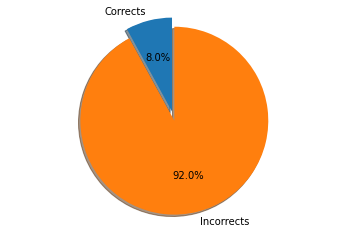

In [50]:
labels = 'Corrects', 'Incorrects'
sizes = [count_correct, 2600-count_correct]
fig1, ax1 = plt.subplots()
explode = (0, 0.1)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

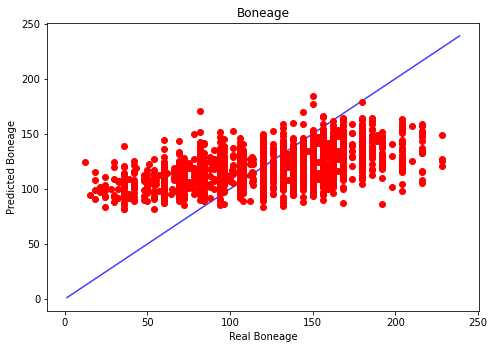

In [44]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_list, res, color='r')
ax.set_xlabel('Real Boneage')
ax.set_ylabel('Predicted Boneage')
ax.set_title('Boneage')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, color="blue")
plt.show()

<h1>Modelo lineal con 15 Epochs</h1>

In [71]:
load_15_age_model = Sequential()
load_15_age_model.add(Conv2D(16, kernel_size=(7,7), strides=(2,2), activation='relu', input_shape=(img_rows, img_cols, 3)))
load_15_age_model.add(Dropout(0.25))

# Convulotional Layers
load_15_age_model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu'))
load_15_age_model.add(Dropout(0.25))
load_15_age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#bone_age_model.add(Dropout(0.25))
load_15_age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
load_15_age_model.add(Dropout(0.25))

# Flattening
load_15_age_model.add(Flatten())

# Dense Layer
load_15_age_model.add(Dense(256, activation='relu'))
#bone_age_model.add(Dropout(0.25))
load_15_age_model.add(Dense(1, activation="linear"))

load_15_age_model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')

In [72]:
load_15_age_model.load_weights('seqModelo_weights_lineal_15.h5')

1/1 [==============================] - 0s 3ms/step


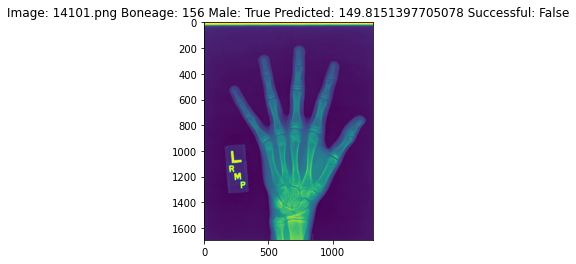

1/1 [==============================] - 0s 3ms/step


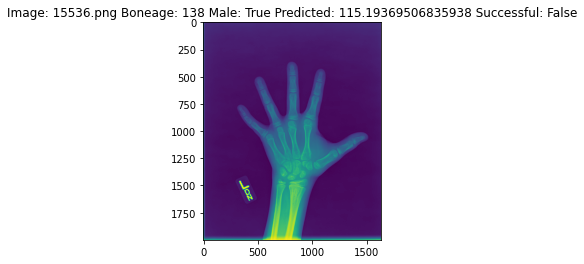

1/1 [==============================] - 0s 4ms/step


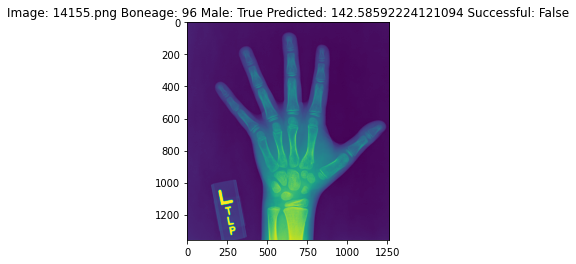

In [73]:
for img_id, boneage, male in test[['id','boneage','male']].sample(3).values:
    filepath = ("./boneage-training-dataset/boneage-training-dataset/"+str(img_id)+".png")
    image = tf.keras.preprocessing.image.load_img(filepath, target_size=(img_rows,img_cols))
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    input_arr=input_arr/256
    predictions = load_15_age_model.predict(input_arr,  verbose = True)
    img_name = str(img_id) + '.png'
    img = mpimg.imread("./boneage-training-dataset/boneage-training-dataset/"+img_name)
    plt.imshow(img)
    dif = boneage-prediction[0][0]
    plt.title('Image: {} Boneage: {} Male: {} Predicted: {} Successful: {}'.format(img_name, boneage, male, predictions[0][0], (dif<4.2 and dif>-4.2)))
    plt.show()

In [16]:
from tkinter import filedialog
filepath = filedialog.askopenfilename()
print(filepath)

C:/Users/Blinkout/Downloads/ModeloSecuencial/boneage-training-dataset/boneage-training-dataset/15609.png


1/1 [==============================] - 0s 964us/step
115.11779


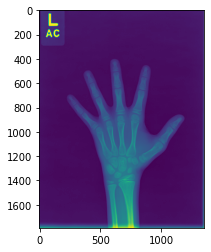

In [81]:
import tensorflow as tf
import PIL

image = tf.keras.preprocessing.image.load_img(filepath, target_size=(img_rows,img_cols))
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr=input_arr/256
predictions = load_15_age_model.predict(input_arr,  verbose = True)
print(predictions[0][0])
img = mpimg.imread(filepath)
plt.imshow(img)
plt.show()

In [74]:
res=[]
for i in range(12705,15611):
    try:
        filepath = ("./boneage-training-dataset/boneage-training-dataset/"+str(i)+".png")
        print(filepath)
        image = tf.keras.preprocessing.image.load_img(filepath, target_size=(img_rows,img_cols))
        input_arr = keras.preprocessing.image.img_to_array(image)
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        input_arr=input_arr/256
        predictions = load_15_age_model.predict(input_arr,  verbose = True)
        res.append(predictions[0][0])
        print(i)
    except:
        pass
print(res)

./boneage-training-dataset/boneage-training-dataset/12705.png
1/1 [==============================] - 0s 998us/step
12705
./boneage-training-dataset/boneage-training-dataset/12706.png
1/1 [==============================] - 0s 970us/step
12706
./boneage-training-dataset/boneage-training-dataset/12707.png
1/1 [==============================] - 0s 2ms/step
12707
./boneage-training-dataset/boneage-training-dataset/12708.png
./boneage-training-dataset/boneage-training-dataset/12709.png
1/1 [==============================] - 0s 1ms/step
12709
./boneage-training-dataset/boneage-training-dataset/12710.png
1/1 [==============================] - 0s 1000us/step
12710
./boneage-training-dataset/boneage-training-dataset/12711.png
1/1 [==============================] - 0s 2ms/step
12711
./boneage-training-dataset/boneage-training-dataset/12712.png
1/1 [==============================] - 0s 999us/step
12712
./boneage-training-dataset/boneage-training-dataset/12713.png
1/1 [=============================

1/1 [==============================] - 0s 987us/step
12775
./boneage-training-dataset/boneage-training-dataset/12776.png
1/1 [==============================] - 0s 1ms/step
12776
./boneage-training-dataset/boneage-training-dataset/12777.png
1/1 [==============================] - 0s 2ms/step
12777
./boneage-training-dataset/boneage-training-dataset/12778.png
1/1 [==============================] - 0s 2ms/step
12778
./boneage-training-dataset/boneage-training-dataset/12779.png
1/1 [==============================] - 0s 1ms/step
12779
./boneage-training-dataset/boneage-training-dataset/12780.png
1/1 [==============================] - 0s 998us/step
12780
./boneage-training-dataset/boneage-training-dataset/12781.png
1/1 [==============================] - 0s 998us/step
12781
./boneage-training-dataset/boneage-training-dataset/12782.png
1/1 [==============================] - 0s 999us/step
12782
./boneage-training-dataset/boneage-training-dataset/12783.png
./boneage-training-dataset/boneage-train

1/1 [==============================] - 0s 963us/step
12849
./boneage-training-dataset/boneage-training-dataset/12850.png
1/1 [==============================] - 0s 970us/step
12850
./boneage-training-dataset/boneage-training-dataset/12851.png
./boneage-training-dataset/boneage-training-dataset/12852.png
1/1 [==============================] - 0s 998us/step
12852
./boneage-training-dataset/boneage-training-dataset/12853.png
1/1 [==============================] - 0s 1ms/step
12853
./boneage-training-dataset/boneage-training-dataset/12854.png
1/1 [==============================] - 0s 997us/step
12854
./boneage-training-dataset/boneage-training-dataset/12855.png
1/1 [==============================] - 0s 1ms/step
12855
./boneage-training-dataset/boneage-training-dataset/12856.png
1/1 [==============================] - 0s 998us/step
12856
./boneage-training-dataset/boneage-training-dataset/12857.png
1/1 [==============================] - 0s 1ms/step
12857
./boneage-training-dataset/boneage-tra

1/1 [==============================] - 0s 995us/step
12921
./boneage-training-dataset/boneage-training-dataset/12922.png
1/1 [==============================] - 0s 0s/step
12922
./boneage-training-dataset/boneage-training-dataset/12923.png
1/1 [==============================] - 0s 3ms/step
12923
./boneage-training-dataset/boneage-training-dataset/12924.png
1/1 [==============================] - 0s 997us/step
12924
./boneage-training-dataset/boneage-training-dataset/12925.png
1/1 [==============================] - 0s 0s/step
12925
./boneage-training-dataset/boneage-training-dataset/12926.png
1/1 [==============================] - 0s 998us/step
12926
./boneage-training-dataset/boneage-training-dataset/12927.png
1/1 [==============================] - 0s 998us/step
12927
./boneage-training-dataset/boneage-training-dataset/12928.png
./boneage-training-dataset/boneage-training-dataset/12929.png
1/1 [==============================] - 0s 1ms/step
12929
./boneage-training-dataset/boneage-trainin

1/1 [==============================] - 0s 997us/step
12994
./boneage-training-dataset/boneage-training-dataset/12995.png
1/1 [==============================] - 0s 2ms/step
12995
./boneage-training-dataset/boneage-training-dataset/12996.png
1/1 [==============================] - 0s 2ms/step
12996
./boneage-training-dataset/boneage-training-dataset/12997.png
1/1 [==============================] - 0s 2ms/step
12997
./boneage-training-dataset/boneage-training-dataset/12998.png
1/1 [==============================] - 0s 962us/step
12998
./boneage-training-dataset/boneage-training-dataset/12999.png
1/1 [==============================] - 0s 999us/step
12999
./boneage-training-dataset/boneage-training-dataset/13000.png
1/1 [==============================] - 0s 1ms/step
13000
./boneage-training-dataset/boneage-training-dataset/13001.png
1/1 [==============================] - 0s 1ms/step
13001
./boneage-training-dataset/boneage-training-dataset/13002.png
./boneage-training-dataset/boneage-trainin

1/1 [==============================] - 0s 1ms/step
13064
./boneage-training-dataset/boneage-training-dataset/13065.png
1/1 [==============================] - 0s 998us/step
13065
./boneage-training-dataset/boneage-training-dataset/13066.png
1/1 [==============================] - 0s 2ms/step
13066
./boneage-training-dataset/boneage-training-dataset/13067.png
1/1 [==============================] - 0s 2ms/step
13067
./boneage-training-dataset/boneage-training-dataset/13068.png
1/1 [==============================] - 0s 1ms/step
13068
./boneage-training-dataset/boneage-training-dataset/13069.png
1/1 [==============================] - 0s 2ms/step
13069
./boneage-training-dataset/boneage-training-dataset/13070.png
1/1 [==============================] - 0s 2ms/step
13070
./boneage-training-dataset/boneage-training-dataset/13071.png
1/1 [==============================] - 0s 2ms/step
13071
./boneage-training-dataset/boneage-training-dataset/13072.png
1/1 [==============================] - 0s 1ms/

1/1 [==============================] - 0s 998us/step
13135
./boneage-training-dataset/boneage-training-dataset/13136.png
1/1 [==============================] - 0s 2ms/step
13136
./boneage-training-dataset/boneage-training-dataset/13137.png
1/1 [==============================] - 0s 2ms/step
13137
./boneage-training-dataset/boneage-training-dataset/13138.png
1/1 [==============================] - 0s 965us/step
13138
./boneage-training-dataset/boneage-training-dataset/13139.png
1/1 [==============================] - 0s 2ms/step
13139
./boneage-training-dataset/boneage-training-dataset/13140.png
1/1 [==============================] - 0s 3ms/step
13140
./boneage-training-dataset/boneage-training-dataset/13141.png
./boneage-training-dataset/boneage-training-dataset/13142.png
./boneage-training-dataset/boneage-training-dataset/13143.png
1/1 [==============================] - 0s 4ms/step
13143
./boneage-training-dataset/boneage-training-dataset/13144.png
1/1 [==============================] - 

13205
./boneage-training-dataset/boneage-training-dataset/13206.png
1/1 [==============================] - 0s 3ms/step
13206
./boneage-training-dataset/boneage-training-dataset/13207.png
1/1 [==============================] - 0s 996us/step
13207
./boneage-training-dataset/boneage-training-dataset/13208.png
1/1 [==============================] - 0s 963us/step
13208
./boneage-training-dataset/boneage-training-dataset/13209.png
1/1 [==============================] - 0s 2ms/step
13209
./boneage-training-dataset/boneage-training-dataset/13210.png
./boneage-training-dataset/boneage-training-dataset/13211.png
1/1 [==============================] - 0s 964us/step
13211
./boneage-training-dataset/boneage-training-dataset/13212.png
1/1 [==============================] - 0s 2ms/step
13212
./boneage-training-dataset/boneage-training-dataset/13213.png
./boneage-training-dataset/boneage-training-dataset/13214.png
1/1 [==============================] - 0s 3ms/step
13214
./boneage-training-dataset/bone

1/1 [==============================] - 0s 2ms/step
13279
./boneage-training-dataset/boneage-training-dataset/13280.png
1/1 [==============================] - 0s 2ms/step
13280
./boneage-training-dataset/boneage-training-dataset/13281.png
./boneage-training-dataset/boneage-training-dataset/13282.png
1/1 [==============================] - 0s 997us/step
13282
./boneage-training-dataset/boneage-training-dataset/13283.png
1/1 [==============================] - 0s 999us/step
13283
./boneage-training-dataset/boneage-training-dataset/13284.png
./boneage-training-dataset/boneage-training-dataset/13285.png
1/1 [==============================] - 0s 963us/step
13285
./boneage-training-dataset/boneage-training-dataset/13286.png
1/1 [==============================] - 0s 995us/step
13286
./boneage-training-dataset/boneage-training-dataset/13287.png
1/1 [==============================] - 0s 971us/step
13287
./boneage-training-dataset/boneage-training-dataset/13288.png
./boneage-training-dataset/boneag

13353
./boneage-training-dataset/boneage-training-dataset/13354.png
./boneage-training-dataset/boneage-training-dataset/13355.png
1/1 [==============================] - 0s 1ms/step
13355
./boneage-training-dataset/boneage-training-dataset/13356.png
1/1 [==============================] - 0s 1ms/step
13356
./boneage-training-dataset/boneage-training-dataset/13357.png
1/1 [==============================] - 0s 960us/step
13357
./boneage-training-dataset/boneage-training-dataset/13358.png
1/1 [==============================] - 0s 1ms/step
13358
./boneage-training-dataset/boneage-training-dataset/13359.png
1/1 [==============================] - 0s 2ms/step
13359
./boneage-training-dataset/boneage-training-dataset/13360.png
1/1 [==============================] - 0s 996us/step
13360
./boneage-training-dataset/boneage-training-dataset/13361.png
1/1 [==============================] - 0s 2ms/step
13361
./boneage-training-dataset/boneage-training-dataset/13362.png
1/1 [============================

1/1 [==============================] - 0s 998us/step
13426
./boneage-training-dataset/boneage-training-dataset/13427.png
1/1 [==============================] - 0s 0s/step
13427
./boneage-training-dataset/boneage-training-dataset/13428.png
1/1 [==============================] - 0s 999us/step
13428
./boneage-training-dataset/boneage-training-dataset/13429.png
1/1 [==============================] - 0s 2ms/step
13429
./boneage-training-dataset/boneage-training-dataset/13430.png
1/1 [==============================] - 0s 2ms/step
13430
./boneage-training-dataset/boneage-training-dataset/13431.png
1/1 [==============================] - 0s 997us/step
13431
./boneage-training-dataset/boneage-training-dataset/13432.png
./boneage-training-dataset/boneage-training-dataset/13433.png
1/1 [==============================] - 0s 2ms/step
13433
./boneage-training-dataset/boneage-training-dataset/13434.png
1/1 [==============================] - 0s 2ms/step
13434
./boneage-training-dataset/boneage-training

1/1 [==============================] - 0s 2ms/step
13499
./boneage-training-dataset/boneage-training-dataset/13500.png
1/1 [==============================] - 0s 0s/step
13500
./boneage-training-dataset/boneage-training-dataset/13501.png
1/1 [==============================] - 0s 998us/step
13501
./boneage-training-dataset/boneage-training-dataset/13502.png
1/1 [==============================] - 0s 970us/step
13502
./boneage-training-dataset/boneage-training-dataset/13503.png
1/1 [==============================] - 0s 963us/step
13503
./boneage-training-dataset/boneage-training-dataset/13504.png
1/1 [==============================] - 0s 1ms/step
13504
./boneage-training-dataset/boneage-training-dataset/13505.png
1/1 [==============================] - 0s 998us/step
13505
./boneage-training-dataset/boneage-training-dataset/13506.png
1/1 [==============================] - 0s 962us/step
13506
./boneage-training-dataset/boneage-training-dataset/13507.png
1/1 [==============================] - 

1/1 [==============================] - 0s 998us/step
13571
./boneage-training-dataset/boneage-training-dataset/13572.png
1/1 [==============================] - 0s 1ms/step
13572
./boneage-training-dataset/boneage-training-dataset/13573.png
1/1 [==============================] - 0s 996us/step
13573
./boneage-training-dataset/boneage-training-dataset/13574.png
1/1 [==============================] - 0s 1ms/step
13574
./boneage-training-dataset/boneage-training-dataset/13575.png
1/1 [==============================] - 0s 963us/step
13575
./boneage-training-dataset/boneage-training-dataset/13576.png
./boneage-training-dataset/boneage-training-dataset/13577.png
./boneage-training-dataset/boneage-training-dataset/13578.png
1/1 [==============================] - 0s 995us/step
13578
./boneage-training-dataset/boneage-training-dataset/13579.png
1/1 [==============================] - 0s 1ms/step
13579
./boneage-training-dataset/boneage-training-dataset/13580.png
1/1 [==============================

1/1 [==============================] - 0s 965us/step
13645
./boneage-training-dataset/boneage-training-dataset/13646.png
1/1 [==============================] - 0s 997us/step
13646
./boneage-training-dataset/boneage-training-dataset/13647.png
1/1 [==============================] - 0s 964us/step
13647
./boneage-training-dataset/boneage-training-dataset/13648.png
1/1 [==============================] - 0s 979us/step
13648
./boneage-training-dataset/boneage-training-dataset/13649.png
1/1 [==============================] - 0s 997us/step
13649
./boneage-training-dataset/boneage-training-dataset/13650.png
./boneage-training-dataset/boneage-training-dataset/13651.png
1/1 [==============================] - 0s 0s/step
13651
./boneage-training-dataset/boneage-training-dataset/13652.png
1/1 [==============================] - 0s 1ms/step
13652
./boneage-training-dataset/boneage-training-dataset/13653.png
1/1 [==============================] - 0s 999us/step
13653
./boneage-training-dataset/boneage-tr

1/1 [==============================] - 0s 2ms/step
13716
./boneage-training-dataset/boneage-training-dataset/13717.png
1/1 [==============================] - 0s 2ms/step
13717
./boneage-training-dataset/boneage-training-dataset/13718.png
1/1 [==============================] - 0s 2ms/step
13718
./boneage-training-dataset/boneage-training-dataset/13719.png
1/1 [==============================] - 0s 2ms/step
13719
./boneage-training-dataset/boneage-training-dataset/13720.png
1/1 [==============================] - 0s 0s/step
13720
./boneage-training-dataset/boneage-training-dataset/13721.png
1/1 [==============================] - 0s 2ms/step
13721
./boneage-training-dataset/boneage-training-dataset/13722.png
./boneage-training-dataset/boneage-training-dataset/13723.png
1/1 [==============================] - 0s 2ms/step
13723
./boneage-training-dataset/boneage-training-dataset/13724.png
./boneage-training-dataset/boneage-training-dataset/13725.png
1/1 [==============================] - 0s 6m

1/1 [==============================] - 0s 998us/step
13789
./boneage-training-dataset/boneage-training-dataset/13790.png
1/1 [==============================] - 0s 1ms/step
13790
./boneage-training-dataset/boneage-training-dataset/13791.png
1/1 [==============================] - 0s 2ms/step
13791
./boneage-training-dataset/boneage-training-dataset/13792.png
1/1 [==============================] - 0s 996us/step
13792
./boneage-training-dataset/boneage-training-dataset/13793.png
1/1 [==============================] - 0s 1ms/step
13793
./boneage-training-dataset/boneage-training-dataset/13794.png
./boneage-training-dataset/boneage-training-dataset/13795.png
1/1 [==============================] - 0s 961us/step
13795
./boneage-training-dataset/boneage-training-dataset/13796.png
1/1 [==============================] - 0s 1ms/step
13796
./boneage-training-dataset/boneage-training-dataset/13797.png
1/1 [==============================] - 0s 970us/step
13797
./boneage-training-dataset/boneage-train

1/1 [==============================] - 0s 2ms/step
13861
./boneage-training-dataset/boneage-training-dataset/13862.png
1/1 [==============================] - 0s 1ms/step
13862
./boneage-training-dataset/boneage-training-dataset/13863.png
1/1 [==============================] - 0s 983us/step
13863
./boneage-training-dataset/boneage-training-dataset/13864.png
./boneage-training-dataset/boneage-training-dataset/13865.png
1/1 [==============================] - 0s 999us/step
13865
./boneage-training-dataset/boneage-training-dataset/13866.png
1/1 [==============================] - 0s 997us/step
13866
./boneage-training-dataset/boneage-training-dataset/13867.png
1/1 [==============================] - 0s 2ms/step
13867
./boneage-training-dataset/boneage-training-dataset/13868.png
1/1 [==============================] - 0s 997us/step
13868
./boneage-training-dataset/boneage-training-dataset/13869.png
1/1 [==============================] - 0s 997us/step
13869
./boneage-training-dataset/boneage-tra

1/1 [==============================] - 0s 2ms/step
13933
./boneage-training-dataset/boneage-training-dataset/13934.png
1/1 [==============================] - 0s 3ms/step
13934
./boneage-training-dataset/boneage-training-dataset/13935.png
1/1 [==============================] - 0s 997us/step
13935
./boneage-training-dataset/boneage-training-dataset/13936.png
1/1 [==============================] - 0s 999us/step
13936
./boneage-training-dataset/boneage-training-dataset/13937.png
1/1 [==============================] - 0s 970us/step
13937
./boneage-training-dataset/boneage-training-dataset/13938.png
1/1 [==============================] - 0s 996us/step
13938
./boneage-training-dataset/boneage-training-dataset/13939.png
1/1 [==============================] - 0s 0s/step
13939
./boneage-training-dataset/boneage-training-dataset/13940.png
./boneage-training-dataset/boneage-training-dataset/13941.png
1/1 [==============================] - 0s 985us/step
13941
./boneage-training-dataset/boneage-trai

1/1 [==============================] - 0s 998us/step
14005
./boneage-training-dataset/boneage-training-dataset/14006.png
1/1 [==============================] - 0s 997us/step
14006
./boneage-training-dataset/boneage-training-dataset/14007.png
1/1 [==============================] - 0s 4ms/step
14007
./boneage-training-dataset/boneage-training-dataset/14008.png
1/1 [==============================] - 0s 965us/step
14008
./boneage-training-dataset/boneage-training-dataset/14009.png
1/1 [==============================] - 0s 999us/step
14009
./boneage-training-dataset/boneage-training-dataset/14010.png
1/1 [==============================] - 0s 0s/step
14010
./boneage-training-dataset/boneage-training-dataset/14011.png
1/1 [==============================] - 0s 1ms/step
14011
./boneage-training-dataset/boneage-training-dataset/14012.png
1/1 [==============================] - 0s 997us/step
14012
./boneage-training-dataset/boneage-training-dataset/14013.png
1/1 [==============================] - 

1/1 [==============================] - 0s 1ms/step
14076
./boneage-training-dataset/boneage-training-dataset/14077.png
1/1 [==============================] - 0s 997us/step
14077
./boneage-training-dataset/boneage-training-dataset/14078.png
1/1 [==============================] - 0s 9ms/step
14078
./boneage-training-dataset/boneage-training-dataset/14079.png
1/1 [==============================] - 0s 1ms/step
14079
./boneage-training-dataset/boneage-training-dataset/14080.png
1/1 [==============================] - 0s 998us/step
14080
./boneage-training-dataset/boneage-training-dataset/14081.png
1/1 [==============================] - 0s 998us/step
14081
./boneage-training-dataset/boneage-training-dataset/14082.png
1/1 [==============================] - 0s 1ms/step
14082
./boneage-training-dataset/boneage-training-dataset/14083.png
1/1 [==============================] - 0s 2ms/step
14083
./boneage-training-dataset/boneage-training-dataset/14084.png
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 1ms/step
14147
./boneage-training-dataset/boneage-training-dataset/14148.png
1/1 [==============================] - 0s 2ms/step
14148
./boneage-training-dataset/boneage-training-dataset/14149.png
1/1 [==============================] - 0s 997us/step
14149
./boneage-training-dataset/boneage-training-dataset/14150.png
./boneage-training-dataset/boneage-training-dataset/14151.png
1/1 [==============================] - 0s 997us/step
14151
./boneage-training-dataset/boneage-training-dataset/14152.png
1/1 [==============================] - 0s 2ms/step
14152
./boneage-training-dataset/boneage-training-dataset/14153.png
1/1 [==============================] - 0s 971us/step
14153
./boneage-training-dataset/boneage-training-dataset/14154.png
1/1 [==============================] - 0s 970us/step
14154
./boneage-training-dataset/boneage-training-dataset/14155.png
1/1 [==============================] - 0s 967us/step
14155
./boneage-training-dataset/boneage-tra

1/1 [==============================] - 0s 2ms/step
14222
./boneage-training-dataset/boneage-training-dataset/14223.png
1/1 [==============================] - 0s 960us/step
14223
./boneage-training-dataset/boneage-training-dataset/14224.png
1/1 [==============================] - 0s 1ms/step
14224
./boneage-training-dataset/boneage-training-dataset/14225.png
1/1 [==============================] - 0s 996us/step
14225
./boneage-training-dataset/boneage-training-dataset/14226.png
1/1 [==============================] - 0s 1ms/step
14226
./boneage-training-dataset/boneage-training-dataset/14227.png
1/1 [==============================] - 0s 1ms/step
14227
./boneage-training-dataset/boneage-training-dataset/14228.png
1/1 [==============================] - 0s 997us/step
14228
./boneage-training-dataset/boneage-training-dataset/14229.png
1/1 [==============================] - 0s 998us/step
14229
./boneage-training-dataset/boneage-training-dataset/14230.png
./boneage-training-dataset/boneage-train

1/1 [==============================] - 0s 997us/step
14292
./boneage-training-dataset/boneage-training-dataset/14293.png
1/1 [==============================] - 0s 996us/step
14293
./boneage-training-dataset/boneage-training-dataset/14294.png
1/1 [==============================] - 0s 3ms/step
14294
./boneage-training-dataset/boneage-training-dataset/14295.png
1/1 [==============================] - 0s 2ms/step
14295
./boneage-training-dataset/boneage-training-dataset/14296.png
1/1 [==============================] - 0s 988us/step
14296
./boneage-training-dataset/boneage-training-dataset/14297.png
1/1 [==============================] - 0s 2ms/step
14297
./boneage-training-dataset/boneage-training-dataset/14298.png
1/1 [==============================] - 0s 992us/step
14298
./boneage-training-dataset/boneage-training-dataset/14299.png
1/1 [==============================] - 0s 2ms/step
14299
./boneage-training-dataset/boneage-training-dataset/14300.png
1/1 [==============================] - 0

1/1 [==============================] - 0s 999us/step
14365
./boneage-training-dataset/boneage-training-dataset/14366.png
1/1 [==============================] - 0s 965us/step
14366
./boneage-training-dataset/boneage-training-dataset/14367.png
1/1 [==============================] - 0s 998us/step
14367
./boneage-training-dataset/boneage-training-dataset/14368.png
1/1 [==============================] - 0s 2ms/step
14368
./boneage-training-dataset/boneage-training-dataset/14369.png
1/1 [==============================] - 0s 998us/step
14369
./boneage-training-dataset/boneage-training-dataset/14370.png
1/1 [==============================] - 0s 997us/step
14370
./boneage-training-dataset/boneage-training-dataset/14371.png
1/1 [==============================] - 0s 1ms/step
14371
./boneage-training-dataset/boneage-training-dataset/14372.png
./boneage-training-dataset/boneage-training-dataset/14373.png
1/1 [==============================] - 0s 969us/step
14373
./boneage-training-dataset/boneage-t

1/1 [==============================] - 0s 998us/step
14436
./boneage-training-dataset/boneage-training-dataset/14437.png
1/1 [==============================] - 0s 995us/step
14437
./boneage-training-dataset/boneage-training-dataset/14438.png
1/1 [==============================] - 0s 963us/step
14438
./boneage-training-dataset/boneage-training-dataset/14439.png
1/1 [==============================] - 0s 3ms/step
14439
./boneage-training-dataset/boneage-training-dataset/14440.png
1/1 [==============================] - 0s 2ms/step
14440
./boneage-training-dataset/boneage-training-dataset/14441.png
1/1 [==============================] - 0s 3ms/step
14441
./boneage-training-dataset/boneage-training-dataset/14442.png
1/1 [==============================] - 0s 2ms/step
14442
./boneage-training-dataset/boneage-training-dataset/14443.png
1/1 [==============================] - 0s 998us/step
14443
./boneage-training-dataset/boneage-training-dataset/14444.png
1/1 [==============================] - 0

1/1 [==============================] - 0s 997us/step
14507
./boneage-training-dataset/boneage-training-dataset/14508.png
1/1 [==============================] - 0s 964us/step
14508
./boneage-training-dataset/boneage-training-dataset/14509.png
1/1 [==============================] - 0s 967us/step
14509
./boneage-training-dataset/boneage-training-dataset/14510.png
1/1 [==============================] - 0s 997us/step
14510
./boneage-training-dataset/boneage-training-dataset/14511.png
1/1 [==============================] - 0s 1ms/step
14511
./boneage-training-dataset/boneage-training-dataset/14512.png
1/1 [==============================] - 0s 2ms/step
14512
./boneage-training-dataset/boneage-training-dataset/14513.png
1/1 [==============================] - 0s 999us/step
14513
./boneage-training-dataset/boneage-training-dataset/14514.png
1/1 [==============================] - 0s 0s/step
14514
./boneage-training-dataset/boneage-training-dataset/14515.png
1/1 [==============================] - 

1/1 [==============================] - 0s 997us/step
14579
./boneage-training-dataset/boneage-training-dataset/14580.png
./boneage-training-dataset/boneage-training-dataset/14581.png
1/1 [==============================] - 0s 975us/step
14581
./boneage-training-dataset/boneage-training-dataset/14582.png
1/1 [==============================] - 0s 960us/step
14582
./boneage-training-dataset/boneage-training-dataset/14583.png
./boneage-training-dataset/boneage-training-dataset/14584.png
1/1 [==============================] - 0s 964us/step
14584
./boneage-training-dataset/boneage-training-dataset/14585.png
1/1 [==============================] - 0s 1ms/step
14585
./boneage-training-dataset/boneage-training-dataset/14586.png
1/1 [==============================] - 0s 998us/step
14586
./boneage-training-dataset/boneage-training-dataset/14587.png
1/1 [==============================] - 0s 962us/step
14587
./boneage-training-dataset/boneage-training-dataset/14588.png
1/1 [==========================

1/1 [==============================] - 0s 996us/step
14652
./boneage-training-dataset/boneage-training-dataset/14653.png
1/1 [==============================] - 0s 999us/step
14653
./boneage-training-dataset/boneage-training-dataset/14654.png
1/1 [==============================] - 0s 2ms/step
14654
./boneage-training-dataset/boneage-training-dataset/14655.png
./boneage-training-dataset/boneage-training-dataset/14656.png
1/1 [==============================] - 0s 978us/step
14656
./boneage-training-dataset/boneage-training-dataset/14657.png
1/1 [==============================] - 0s 997us/step
14657
./boneage-training-dataset/boneage-training-dataset/14658.png
1/1 [==============================] - 0s 1ms/step
14658
./boneage-training-dataset/boneage-training-dataset/14659.png
1/1 [==============================] - 0s 962us/step
14659
./boneage-training-dataset/boneage-training-dataset/14660.png
./boneage-training-dataset/boneage-training-dataset/14661.png
1/1 [============================

1/1 [==============================] - 0s 1ms/step
14726
./boneage-training-dataset/boneage-training-dataset/14727.png
1/1 [==============================] - 0s 971us/step
14727
./boneage-training-dataset/boneage-training-dataset/14728.png
1/1 [==============================] - 0s 1ms/step
14728
./boneage-training-dataset/boneage-training-dataset/14729.png
1/1 [==============================] - 0s 998us/step
14729
./boneage-training-dataset/boneage-training-dataset/14730.png
./boneage-training-dataset/boneage-training-dataset/14731.png
./boneage-training-dataset/boneage-training-dataset/14732.png
1/1 [==============================] - 0s 997us/step
14732
./boneage-training-dataset/boneage-training-dataset/14733.png
1/1 [==============================] - 0s 998us/step
14733
./boneage-training-dataset/boneage-training-dataset/14734.png
./boneage-training-dataset/boneage-training-dataset/14735.png
1/1 [==============================] - 0s 1ms/step
14735
./boneage-training-dataset/boneage-

1/1 [==============================] - 0s 996us/step
14800
./boneage-training-dataset/boneage-training-dataset/14801.png
1/1 [==============================] - 0s 997us/step
14801
./boneage-training-dataset/boneage-training-dataset/14802.png
1/1 [==============================] - 0s 0s/step
14802
./boneage-training-dataset/boneage-training-dataset/14803.png
1/1 [==============================] - 0s 1ms/step
14803
./boneage-training-dataset/boneage-training-dataset/14804.png
1/1 [==============================] - 0s 1ms/step
14804
./boneage-training-dataset/boneage-training-dataset/14805.png
1/1 [==============================] - 0s 2ms/step
14805
./boneage-training-dataset/boneage-training-dataset/14806.png
1/1 [==============================] - 0s 966us/step
14806
./boneage-training-dataset/boneage-training-dataset/14807.png
./boneage-training-dataset/boneage-training-dataset/14808.png
1/1 [==============================] - 0s 2ms/step
14808
./boneage-training-dataset/boneage-training

1/1 [==============================] - 0s 1ms/step
14869
./boneage-training-dataset/boneage-training-dataset/14870.png
1/1 [==============================] - 0s 2ms/step
14870
./boneage-training-dataset/boneage-training-dataset/14871.png
1/1 [==============================] - 0s 997us/step
14871
./boneage-training-dataset/boneage-training-dataset/14872.png
1/1 [==============================] - 0s 1ms/step
14872
./boneage-training-dataset/boneage-training-dataset/14873.png
1/1 [==============================] - 0s 0s/step
14873
./boneage-training-dataset/boneage-training-dataset/14874.png
1/1 [==============================] - 0s 840us/step
14874
./boneage-training-dataset/boneage-training-dataset/14875.png
1/1 [==============================] - 0s 970us/step
14875
./boneage-training-dataset/boneage-training-dataset/14876.png
1/1 [==============================] - 0s 3ms/step
14876
./boneage-training-dataset/boneage-training-dataset/14877.png
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 996us/step
14941
./boneage-training-dataset/boneage-training-dataset/14942.png
1/1 [==============================] - 0s 998us/step
14942
./boneage-training-dataset/boneage-training-dataset/14943.png
1/1 [==============================] - 0s 997us/step
14943
./boneage-training-dataset/boneage-training-dataset/14944.png
1/1 [==============================] - 0s 996us/step
14944
./boneage-training-dataset/boneage-training-dataset/14945.png
1/1 [==============================] - 0s 1ms/step
14945
./boneage-training-dataset/boneage-training-dataset/14946.png
1/1 [==============================] - 0s 965us/step
14946
./boneage-training-dataset/boneage-training-dataset/14947.png
1/1 [==============================] - 0s 0s/step
14947
./boneage-training-dataset/boneage-training-dataset/14948.png
./boneage-training-dataset/boneage-training-dataset/14949.png
1/1 [==============================] - 0s 998us/step
14949
./boneage-training-dataset/boneage-tr

1/1 [==============================] - 0s 963us/step
15013
./boneage-training-dataset/boneage-training-dataset/15014.png
1/1 [==============================] - 0s 1ms/step
15014
./boneage-training-dataset/boneage-training-dataset/15015.png
1/1 [==============================] - 0s 0s/step
15015
./boneage-training-dataset/boneage-training-dataset/15016.png
1/1 [==============================] - 0s 2ms/step
15016
./boneage-training-dataset/boneage-training-dataset/15017.png
./boneage-training-dataset/boneage-training-dataset/15018.png
1/1 [==============================] - 0s 998us/step
15018
./boneage-training-dataset/boneage-training-dataset/15019.png
1/1 [==============================] - 0s 2ms/step
15019
./boneage-training-dataset/boneage-training-dataset/15020.png
1/1 [==============================] - 0s 1ms/step
15020
./boneage-training-dataset/boneage-training-dataset/15021.png
1/1 [==============================] - 0s 2ms/step
15021
./boneage-training-dataset/boneage-training-d

1/1 [==============================] - 0s 999us/step
15087
./boneage-training-dataset/boneage-training-dataset/15088.png
1/1 [==============================] - 0s 998us/step
15088
./boneage-training-dataset/boneage-training-dataset/15089.png
1/1 [==============================] - 0s 997us/step
15089
./boneage-training-dataset/boneage-training-dataset/15090.png
1/1 [==============================] - 0s 1ms/step
15090
./boneage-training-dataset/boneage-training-dataset/15091.png
1/1 [==============================] - 0s 992us/step
15091
./boneage-training-dataset/boneage-training-dataset/15092.png
1/1 [==============================] - 0s 998us/step
15092
./boneage-training-dataset/boneage-training-dataset/15093.png
1/1 [==============================] - 0s 997us/step
15093
./boneage-training-dataset/boneage-training-dataset/15094.png
1/1 [==============================] - 0s 998us/step
15094
./boneage-training-dataset/boneage-training-dataset/15095.png
1/1 [=============================

1/1 [==============================] - 0s 992us/step
15156
./boneage-training-dataset/boneage-training-dataset/15157.png
1/1 [==============================] - 0s 997us/step
15157
./boneage-training-dataset/boneage-training-dataset/15158.png
1/1 [==============================] - 0s 4ms/step
15158
./boneage-training-dataset/boneage-training-dataset/15159.png
1/1 [==============================] - 0s 3ms/step
15159
./boneage-training-dataset/boneage-training-dataset/15160.png
1/1 [==============================] - 0s 993us/step
15160
./boneage-training-dataset/boneage-training-dataset/15161.png
1/1 [==============================] - 0s 997us/step
15161
./boneage-training-dataset/boneage-training-dataset/15162.png
1/1 [==============================] - 0s 998us/step
15162
./boneage-training-dataset/boneage-training-dataset/15163.png
1/1 [==============================] - 0s 2ms/step
15163
./boneage-training-dataset/boneage-training-dataset/15164.png
1/1 [==============================] -

1/1 [==============================] - 0s 998us/step
15227
./boneage-training-dataset/boneage-training-dataset/15228.png
1/1 [==============================] - 0s 990us/step
15228
./boneage-training-dataset/boneage-training-dataset/15229.png
1/1 [==============================] - 0s 972us/step
15229
./boneage-training-dataset/boneage-training-dataset/15230.png
1/1 [==============================] - 0s 999us/step
15230
./boneage-training-dataset/boneage-training-dataset/15231.png
1/1 [==============================] - 0s 2ms/step
15231
./boneage-training-dataset/boneage-training-dataset/15232.png
1/1 [==============================] - 0s 1ms/step
15232
./boneage-training-dataset/boneage-training-dataset/15233.png
1/1 [==============================] - 0s 2ms/step
15233
./boneage-training-dataset/boneage-training-dataset/15234.png
1/1 [==============================] - 0s 999us/step
15234
./boneage-training-dataset/boneage-training-dataset/15235.png
1/1 [==============================] -

1/1 [==============================] - 0s 1ms/step
15298
./boneage-training-dataset/boneage-training-dataset/15299.png
1/1 [==============================] - 0s 965us/step
15299
./boneage-training-dataset/boneage-training-dataset/15300.png
1/1 [==============================] - 0s 1ms/step
15300
./boneage-training-dataset/boneage-training-dataset/15301.png
1/1 [==============================] - 0s 963us/step
15301
./boneage-training-dataset/boneage-training-dataset/15302.png
1/1 [==============================] - 0s 2ms/step
15302
./boneage-training-dataset/boneage-training-dataset/15303.png
1/1 [==============================] - 0s 2ms/step
15303
./boneage-training-dataset/boneage-training-dataset/15304.png
1/1 [==============================] - 0s 966us/step
15304
./boneage-training-dataset/boneage-training-dataset/15305.png
./boneage-training-dataset/boneage-training-dataset/15306.png
1/1 [==============================] - 0s 2ms/step
15306
./boneage-training-dataset/boneage-trainin

1/1 [==============================] - 0s 1ms/step
15369
./boneage-training-dataset/boneage-training-dataset/15370.png
./boneage-training-dataset/boneage-training-dataset/15371.png
1/1 [==============================] - 0s 2ms/step
15371
./boneage-training-dataset/boneage-training-dataset/15372.png
1/1 [==============================] - 0s 2ms/step
15372
./boneage-training-dataset/boneage-training-dataset/15373.png
1/1 [==============================] - 0s 965us/step
15373
./boneage-training-dataset/boneage-training-dataset/15374.png
1/1 [==============================] - 0s 1ms/step
15374
./boneage-training-dataset/boneage-training-dataset/15375.png
1/1 [==============================] - 0s 2ms/step
15375
./boneage-training-dataset/boneage-training-dataset/15376.png
1/1 [==============================] - 0s 0s/step
15376
./boneage-training-dataset/boneage-training-dataset/15377.png
1/1 [==============================] - 0s 3ms/step
15377
./boneage-training-dataset/boneage-training-dat

1/1 [==============================] - 0s 2ms/step
15440
./boneage-training-dataset/boneage-training-dataset/15441.png
1/1 [==============================] - 0s 997us/step
15441
./boneage-training-dataset/boneage-training-dataset/15442.png
1/1 [==============================] - 0s 2ms/step
15442
./boneage-training-dataset/boneage-training-dataset/15443.png
1/1 [==============================] - 0s 2ms/step
15443
./boneage-training-dataset/boneage-training-dataset/15444.png
1/1 [==============================] - 0s 1ms/step
15444
./boneage-training-dataset/boneage-training-dataset/15445.png
1/1 [==============================] - 0s 962us/step
15445
./boneage-training-dataset/boneage-training-dataset/15446.png
1/1 [==============================] - 0s 998us/step
15446
./boneage-training-dataset/boneage-training-dataset/15447.png
1/1 [==============================] - 0s 1ms/step
15447
./boneage-training-dataset/boneage-training-dataset/15448.png
./boneage-training-dataset/boneage-trainin

1/1 [==============================] - 0s 1ms/step
15513
./boneage-training-dataset/boneage-training-dataset/15514.png
1/1 [==============================] - 0s 998us/step
15514
./boneage-training-dataset/boneage-training-dataset/15515.png
1/1 [==============================] - 0s 1ms/step
15515
./boneage-training-dataset/boneage-training-dataset/15516.png
1/1 [==============================] - 0s 2ms/step
15516
./boneage-training-dataset/boneage-training-dataset/15517.png
1/1 [==============================] - 0s 1ms/step
15517
./boneage-training-dataset/boneage-training-dataset/15518.png
1/1 [==============================] - 0s 977us/step
15518
./boneage-training-dataset/boneage-training-dataset/15519.png
1/1 [==============================] - 0s 996us/step
15519
./boneage-training-dataset/boneage-training-dataset/15520.png
1/1 [==============================] - 0s 2ms/step
15520
./boneage-training-dataset/boneage-training-dataset/15521.png
./boneage-training-dataset/boneage-trainin

1/1 [==============================] - 0s 963us/step
15586
./boneage-training-dataset/boneage-training-dataset/15587.png
1/1 [==============================] - 0s 2ms/step
15587
./boneage-training-dataset/boneage-training-dataset/15588.png
1/1 [==============================] - 0s 1ms/step
15588
./boneage-training-dataset/boneage-training-dataset/15589.png
1/1 [==============================] - 0s 997us/step
15589
./boneage-training-dataset/boneage-training-dataset/15590.png
./boneage-training-dataset/boneage-training-dataset/15591.png
1/1 [==============================] - 0s 994us/step
15591
./boneage-training-dataset/boneage-training-dataset/15592.png
./boneage-training-dataset/boneage-training-dataset/15593.png
1/1 [==============================] - 0s 1000us/step
15593
./boneage-training-dataset/boneage-training-dataset/15594.png
1/1 [==============================] - 0s 1ms/step
15594
./boneage-training-dataset/boneage-training-dataset/15595.png
1/1 [=============================

In [75]:
test_array=(np.array(test["boneage"]))
test_list=(test_array.tolist())
print(test_list)

[156, 94, 120, 168, 132, 156, 94, 156, 72, 108, 168, 144, 94, 192, 150, 94, 150, 94, 120, 168, 174, 106, 156, 138, 168, 60, 168, 108, 156, 180, 156, 210, 204, 144, 69, 94, 174, 120, 168, 156, 156, 156, 150, 108, 72, 84, 132, 54, 42, 162, 132, 106, 50, 150, 144, 132, 150, 174, 138, 102, 72, 138, 82, 138, 84, 150, 168, 120, 156, 120, 204, 94, 82, 82, 106, 138, 162, 42, 94, 156, 84, 216, 106, 120, 120, 96, 77, 24, 144, 132, 204, 108, 162, 120, 138, 144, 156, 168, 96, 69, 106, 132, 36, 150, 72, 60, 84, 120, 138, 114, 120, 144, 150, 69, 138, 126, 204, 156, 108, 54, 84, 153, 108, 168, 180, 132, 36, 60, 82, 108, 54, 106, 113, 150, 162, 96, 120, 132, 138, 138, 144, 162, 120, 156, 174, 101, 144, 100, 106, 96, 156, 138, 162, 150, 204, 156, 108, 156, 162, 150, 132, 82, 168, 192, 150, 60, 138, 156, 168, 144, 150, 132, 162, 192, 60, 150, 162, 189, 132, 156, 150, 156, 156, 60, 96, 168, 57, 144, 94, 144, 144, 94, 120, 168, 150, 162, 94, 94, 69, 132, 138, 156, 162, 108, 150, 162, 48, 162, 94, 180, 150

In [76]:
diferences=[]
for i in range(len(test_list)):
    diferences.append(test_list[i]-res[i])
print(diferences)


[14.380355834960938, -36.41374206542969, -12.558578491210938, 30.494186401367188, -1.352996826171875, 39.944671630859375, -46.25408935546875, 31.21240997314453, -57.5791015625, -18.31780242919922, 43.32738494873047, -31.79095458984375, -3.1393356323242188, 55.7486572265625, -3.4771881103515625, -31.342262268066406, 1.2889556884765625, -45.508819580078125, -26.695098876953125, 43.001068115234375, 27.657424926757812, -12.881515502929688, 36.02986145019531, 18.37744903564453, 19.11102294921875, -62.91886901855469, 26.49896240234375, -28.9620361328125, 21.472381591796875, 26.741729736328125, 20.456512451171875, 72.48782348632812, 67.00999450683594, 18.353790283203125, -46.858238220214844, -38.9853515625, 11.915756225585938, -12.291091918945312, 29.447265625, 16.608200073242188, 27.78558349609375, 17.691619873046875, 3.7091217041015625, -19.225677490234375, -58.75114440917969, -30.697959899902344, -6.685760498046875, -60.34459686279297, -84.06238555908203, 25.456192016601562, 9.969772338867

In [77]:
cuadrados=[]
for i in((diferences)):
    cuadrados.append(i*i)
print("Error cuadrado medio: "+str(sum(cuadrados)/len(cuadrados)))
absolutos=[]
for i in((diferences)):
    if(i<0):
        absolutos.append(i*-1)
    else:
        absolutos.append(i)
print("Error medio absoluto: "+str(sum(absolutos)/len(absolutos)))

Error cuadrado medio: 1154.5854026374718
Error medio absoluto: 27.34918539780837


In [78]:
count_correct=0
for i in diferences:
    if (i<4.2 and i>-4.2):
        count_correct = count_correct + 1

acc = count_correct/2600

print("Accuracy: "+str(acc*100)+"%")

Accuracy: 9.307692307692307%


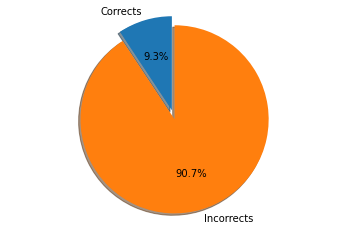

In [79]:
labels = 'Corrects', 'Incorrects'
sizes = [count_correct, 2600-count_correct]
fig1, ax1 = plt.subplots()
explode = (0, 0.1)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

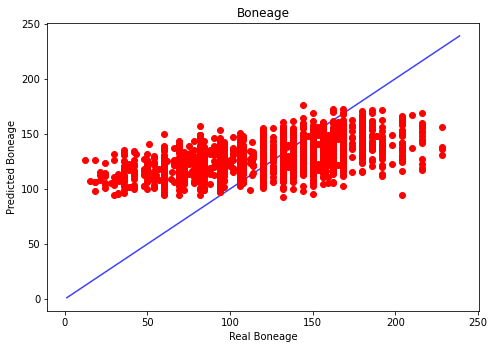

In [80]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(test_list, res, color='r')
ax.set_xlabel('Real Boneage')
ax.set_ylabel('Predicted Boneage')
ax.set_title('Boneage')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, color="blue")
plt.show()